In [3]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import MH2d

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

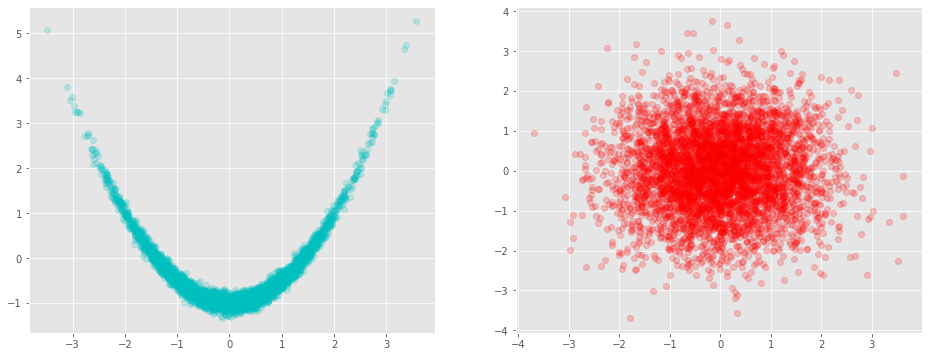

In [4]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0, start_height = -1)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

### Define an NVP-based normalizing flow

In [5]:
# Create model object
nvp = NVP(num_layers=3, neuron_list=[3,3])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=2e-3, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

### Print a summary of the model

In [6]:
nvp.summary()

Model: "NVP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________


### Train the model using ADAM

In [7]:
# Define training options
n_epochs = 50
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 2.3384
Epoch 2/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 2.0754
Epoch 3/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.9890
Epoch 4/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.8838
Epoch 5/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 1.5676
Epoch 6/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 0.9145
Epoch 7/50
100/100 [==============================] - 2s 18ms/step - Negative Log Likelihood: 0.6872
Epoch 8/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 0.6225
Epoch 9/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likelihood: 0.5996
Epoch 10/50
100/100 [==============================] - 2s 16ms/step - Negative Log Likeliho

### Plot the training history

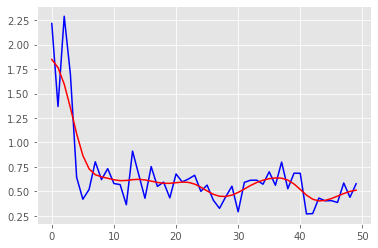

In [8]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(history.history['Negative Log Likelihood'],'b')
plt.plot(ysmoothed, color = 'r')

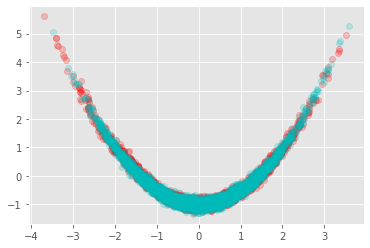

In [9]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

## Conditional Sampling using Metropolis Hastings

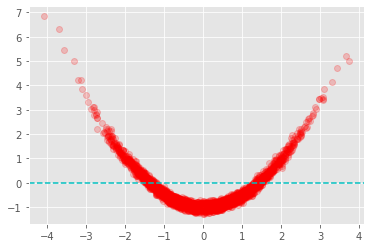

In [10]:
# We want to draw condition samples from about y = 0.0
y_star = 0.0

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [ ]:
# Run the algorithm
acc_rate, samples = MH2d(nvp, y_star = 0.0)
print(acc_rate)

it: 0 time: 0.5367846488952637
it: 1000 time: 7.8633997440338135
it: 2000 time: 7.439005136489868
it: 3000 time: 7.892668724060059
it: 4000 time: 8.168383359909058
it: 5000 time: 7.956410646438599
it: 6000 time: 7.761447429656982
it: 7000 time: 7.7496044635772705


In [ ]:
# Plot the conditional samples
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples, 150, (-5, 5), color='r', alpha=.8, density=True, zorder=10)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-3, 3))